In [1]:
import pandas as pd
import pickle

In [5]:
outfit_data = pd.read_csv("../dataset/outfit_data_preprocessed.csv")
product_data = pd.read_csv("../dataset/product_data_cleaned.csv")

In [6]:
outfit_data.head()

,cod_outfit,cod_modelo_color
0,1,51000622-02
1,1,43067759-01
2,1,53060518-02
3,1,53030594-08
4,1,43077762-01


In [7]:
product_counts = outfit_data.groupby('cod_modelo_color').size().reset_index(name='counts')

merged_df = pd.merge(outfit_data, outfit_data, how='left', on='cod_outfit')
merged_df = merged_df[merged_df['cod_modelo_color_x'] > merged_df['cod_modelo_color_y']]
merged_df = merged_df.groupby(['cod_modelo_color_x', 'cod_modelo_color_y']).size().reset_index(name='weight')

In [8]:
merged_df.head()

,cod_modelo_color_x,cod_modelo_color_y,weight
0,41041002-02,41039067-05,1
1,41045021-02,41025020-02,1
2,41045815-45,41039067-05,1
3,41065822-50,41055822-08,1
4,41083009-08,41069066-05,2


In [9]:
merged_df = pd.merge(merged_df, product_counts, how='left', left_on='cod_modelo_color_x', right_on='cod_modelo_color')
merged_df['weight'] = merged_df['weight'] / merged_df['counts']
merged_df['edge'] = merged_df.apply(lambda x: (x['cod_modelo_color_y'], x['weight']), axis=1)
merged_df = merged_df.groupby('cod_modelo_color_x').agg({'edge': lambda x: list(x)})
merged_df.head()

,edge
cod_modelo_color_x,
41041002-02,"[(41039067-05, 0.5)]"
41045021-02,"[(41025020-02, 0.14285714285714285)]"
41045815-45,"[(41039067-05, 0.25)]"
41065822-50,"[(41055822-08, 1.0)]"
41083009-08,"[(41069066-05, 0.14285714285714285)]"


In [10]:
import networkx as nx

G = nx.Graph()

for row in merged_df.iterrows():
    nodei = row[0]
    for edge in row[1]['edge']:
        nodej = edge[0]
        G.add_edge(nodei, nodej, weight=edge[1])

In [13]:
communities = nx.community.louvain_communities(G, weight="weight", resolution=7)
communities = list(communities)

In [17]:
data = []
for i, community in enumerate(communities):
    data += [(i, item) for item in community]
    
df = pd.DataFrame(data, columns=['community_id', 'cod_modelo_color'])
df.head()

,community_id,cod_modelo_color
0,0,53060637-92
1,0,53003715-02
2,0,53070609-02
3,0,41047044-20
4,0,53070609-28


<Axes: >

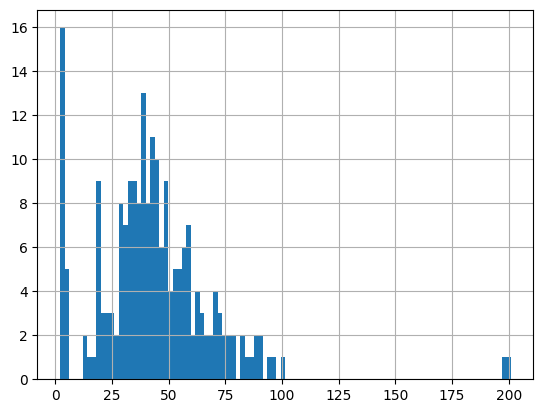

In [15]:
df["community_id"].value_counts().hist(bins=100)

In [58]:
compatibilities = {}
for i, community in enumerate(communities):
    for item in community:
        compatibilities[item] = i
               
with open('../dataset/compatibilities.pickle', 'wb') as handle:
    pickle.dump(compatibilities, handle, protocol=pickle.HIGHEST_PROTOCOL)